In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torchvision

'''
1. train specific blocks 
2. change the weights 
3.augementation, hflip
4.add more cnn layers max 3 linear layers
'''

In [3]:
DATADIR = "/home/khushi/Testing_testing/Data/Updated_Data"
categories = ["Anaesthesia_machine","baby_incubator","Bone_saws","C_arm","colonoscope","Curved_Mayo_Scissor","difibrillator","Electrocautery_devices","fetal_doppler","forceps","Heart_Lung_Machine","IABP","IMRT","infusion_pump","Laryngoscopes","mayfield_clamp","Needle_Biopsy_Device","phacoemulsification","Radiofrequency_Ablation_Device","Scalpel","Straight_Dissection_Clamp","Straight_Mayo_Scissor","Suction_Machine","ventilator","x_ray"]
input_size = (224, 224)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, categories, input_size, transform=None):
        self.data_dir = data_dir
        self.categories = categories
        self.input_size = input_size
        self.transform = transform
        self.data = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for cat in self.categories:
            path = os.path.join(self.data_dir, cat)
            class_num = self.categories.index(cat)
            for img_name in os.listdir(path):
                try:
                    img_path = os.path.join(path, img_name)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(self.input_size)
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(class_num)
                except Exception as e:
                    pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        return img, label

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
   
])

dataset = CustomDataset(DATADIR, categories, input_size, transform=transform)

train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
'''
import os
from torchvision.utils import save_image

# Create directories to store the images
os.makedirs("train_images", exist_ok=True)
os.makedirs("test_images", exist_ok=True)

# Save training images
for i, (images, labels) in enumerate(train_loader):
    for j in range(images.size(0)):
        image_name = f"train_image_{i * batch_size + j}.png"
        save_image(images[j], os.path.join("train_images", image_name))

# Save test images
for i, (images, labels) in enumerate(test_loader):
    for j in range(images.size(0)):
        image_name = f"test_image_{i * batch_size + j}.png"
        save_image(images[j], os.path.join("test_images", image_name))'''



'\nimport os\nfrom torchvision.utils import save_image\n\n# Create directories to store the images\nos.makedirs("train_images", exist_ok=True)\nos.makedirs("test_images", exist_ok=True)\n\n# Save training images\nfor i, (images, labels) in enumerate(train_loader):\n    for j in range(images.size(0)):\n        image_name = f"train_image_{i * batch_size + j}.png"\n        save_image(images[j], os.path.join("train_images", image_name))\n\n# Save test images\nfor i, (images, labels) in enumerate(test_loader):\n    for j in range(images.size(0)):\n        image_name = f"test_image_{i * batch_size + j}.png"\n        save_image(images[j], os.path.join("test_images", image_name))'

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Assuming you have already defined the CustomDataset class, DATADIR, categories, and input_size variables.

# Define the custom ResNet model
'''

class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        
        # Replace the final fully connected layer of the base model
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),                  # Dropout layer for regularization
            nn.Linear(num_features, 64),
            nn.Dropout(0.7),     
        
            
            nn.ReLU(),

            nn.Linear(64, num_classes)       # Final output layer
        )
        self.l2_lambda = 0.01

    def forward(self, x):

          
        x = self.base_model(x)
        
        
       
        
        return x'''





class CustomResNet(nn.Module):
    def __init__(self, num_classes, fine_tune_layers=3):
        super(CustomResNet, self).__init__()
        res = models.resnet152(pretrained=True)
        self.res = nn.Sequential(*list(res.children())[:-1])

        # Freeze all layers by default
        for param in res.parameters():
            param.requires_grad = False

        # Make the last block trainable
        '''for layer in res.features[-fine_tune_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

        for param in res.classifier.parameters():
            param.requires_grad = True
'''
        #self.res = res
        
        # Create the custom head (additional dense layers)
        # self.head = nn.Sequential(
           
        #    #nn.Linear(2048),
        #     #nn.ReLU(),
        #     #nn.Dropout(0.5),
        #     #nn.Linear(4096, 2048),
        #     #nn.ReLU(),
        #     #nn.Dropout(0.3),
        #     nn.Linear(2048,512),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(512, num_classes),
            
        # )
        # self.convlayers = nn.Sequential(
        #     nn.conv2d(64, 32, kernel_size = 3), 

        #     nn.ReLU(),

        #     nn.conv2d(32,16, kernel_size = 3),

        self.convlayers = nn.Sequential(

            nn.Conv2d(2048, 512, kernel_size = 3, padding = 1, stride = 1), 

            nn.ReLU(),

            nn.Conv2d(512, 128, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size = 1),

            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(128, 25) )    
    def forward(self, x):
        x = self.res(x)
        #x = torch.flatten(x, 1)
        x = self.convlayers(x)
        return x
    '''
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        
        # Replace the final fully connected layer of the base model
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_classes)

        # Add L2 regularization to the model
        self.l2_loss = nn.MSELoss()

    def forward(self, x):
        x = self.base_model(x)
        loss = self.l2_loss(x)
        return loss'''

In [9]:

num_classes = len(categories)
model = CustomResNet(num_classes).to(device)
for name, param in model.named_parameters():
     print(f"{name}: requires_grad={param.requires_grad}")

print(model)

/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


res.0.weight: requires_grad=False
res.1.weight: requires_grad=False
res.1.bias: requires_grad=False
res.4.0.conv1.weight: requires_grad=False
res.4.0.bn1.weight: requires_grad=False
res.4.0.bn1.bias: requires_grad=False
res.4.0.conv2.weight: requires_grad=False
res.4.0.bn2.weight: requires_grad=False
res.4.0.bn2.bias: requires_grad=False
res.4.0.conv3.weight: requires_grad=False
res.4.0.bn3.weight: requires_grad=False
res.4.0.bn3.bias: requires_grad=False
res.4.0.downsample.0.weight: requires_grad=False
res.4.0.downsample.1.weight: requires_grad=False
res.4.0.downsample.1.bias: requires_grad=False
res.4.1.conv1.weight: requires_grad=False
res.4.1.bn1.weight: requires_grad=False
res.4.1.bn1.bias: requires_grad=False
res.4.1.conv2.weight: requires_grad=False
res.4.1.bn2.weight: requires_grad=False
res.4.1.bn2.bias: requires_grad=False
res.4.1.conv3.weight: requires_grad=False
res.4.1.bn3.weight: requires_grad=False
res.4.1.bn3.bias: requires_grad=False
res.4.2.conv1.weight: requires_grad

In [10]:
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
training_loss_li=[]
training_accuracy_li=[]
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    
    train_accuracy= correct_predictions / len(train_dataset)
    
    
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")

'''

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# training_loss_li=[]
# training_accuracy_li=[]
# # Training loop
# num_epochs = 5
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
       
        
#         loss = criterion(outputs,labels)
#         loss.backward()

#         optimizer.step()
        
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct_predictions += (predicted == labels).sum().item()
    
#     train_loss = running_loss / len(train_loader)
    
#     train_accuracy= correct_predictions / len(train_dataset)
    
    
    
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")



'\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)\ntraining_loss_li=[]\ntraining_accuracy_li=[]\n# Training loop\nnum_epochs = 50\nfor epoch in range(num_epochs):\n    model.train()\n    running_loss = 0.0\n    correct_predictions = 0\n    \n    for images, labels in train_loader:\n        images, labels = images.to(device), labels.to(device)\n        optimizer.zero_grad()\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        \n        running_loss += loss.item()\n        _, predicted = torch.max(outputs, 1)\n        correct_predictions += (predicted == labels).sum().item()\n    \n    train_loss = running_loss / len(train_loader)\n    \n    train_accuracy= correct_predictions / len(train_dataset)\n    \n    \n    \n    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")\n\n'

In [11]:
# Testing loop
'''
model.eval()
running_loss = 0.0
correct_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

test_loss = running_loss / len(test_loader)
test_accuracy = correct_predictions / len(test_dataset)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

'''

'\nmodel.eval()\nrunning_loss = 0.0\ncorrect_predictions = 0\n\nwith torch.no_grad():\n    for images, labels in test_loader:\n        images, labels = images.to(device), labels.to(device)\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n        running_loss += loss.item()\n        _, predicted = torch.max(outputs, 1)\n        correct_predictions += (predicted == labels).sum().item()\n\ntest_loss = running_loss / len(test_loader)\ntest_accuracy = correct_predictions / len(test_dataset)\n\nprint(f"Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.4f}")\n\n'

In [12]:
train_acc_history = []
train_loss_history = []
test_acc_history = []
test_loss_history = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00105, weight_decay=1e-5)
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss, train_corrects = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        labels = torch.squeeze(labels)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels).item()

    train_loss = train_loss / len(train_dataset)
    train_acc = train_corrects / len(train_dataset)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss, val_corrects = 0.0, 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()

    val_loss = val_loss / len(test_dataset)
    val_acc = val_corrects / len(test_dataset)

    test_acc_history.append(val_acc)
    test_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



Epoch 1/25 | Train Loss: 2.5013 | Train Acc: 0.1957 | Val Loss: 1.8076 | Val Acc: 0.3525
Epoch 2/25 | Train Loss: 1.6065 | Train Acc: 0.4383 | Val Loss: 1.3680 | Val Acc: 0.5324
Epoch 3/25 | Train Loss: 1.2547 | Train Acc: 0.5665 | Val Loss: 1.1711 | Val Acc: 0.5994
Epoch 4/25 | Train Loss: 1.0735 | Train Acc: 0.6272 | Val Loss: 1.0073 | Val Acc: 0.6590
Epoch 5/25 | Train Loss: 0.9073 | Train Acc: 0.6978 | Val Loss: 0.9319 | Val Acc: 0.6998
Epoch 6/25 | Train Loss: 0.7909 | Train Acc: 0.7425 | Val Loss: 0.7770 | Val Acc: 0.7542
Epoch 7/25 | Train Loss: 0.7081 | Train Acc: 0.7711 | Val Loss: 0.7594 | Val Acc: 0.7552
Epoch 8/25 | Train Loss: 0.6196 | Train Acc: 0.8014 | Val Loss: 0.8020 | Val Acc: 0.7584
Epoch 9/25 | Train Loss: 0.5678 | Train Acc: 0.8137 | Val Loss: 0.7147 | Val Acc: 0.7772
Epoch 10/25 | Train Loss: 0.4970 | Train Acc: 0.8386 | Val Loss: 0.6756 | Val Acc: 0.7960
Epoch 11/25 | Train Loss: 0.4522 | Train Acc: 0.8590 | Val Loss: 0.6318 | Val Acc: 0.8190
Epoch 12/25 | Train

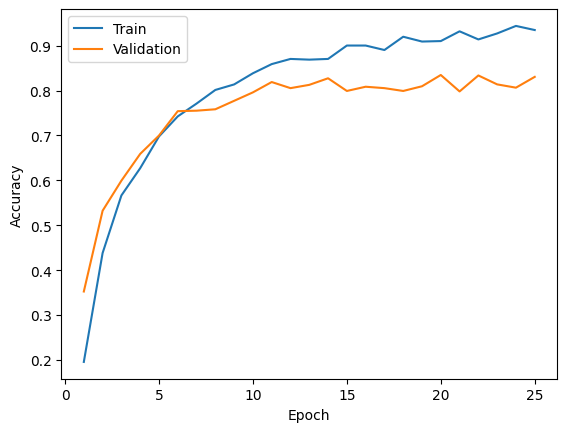

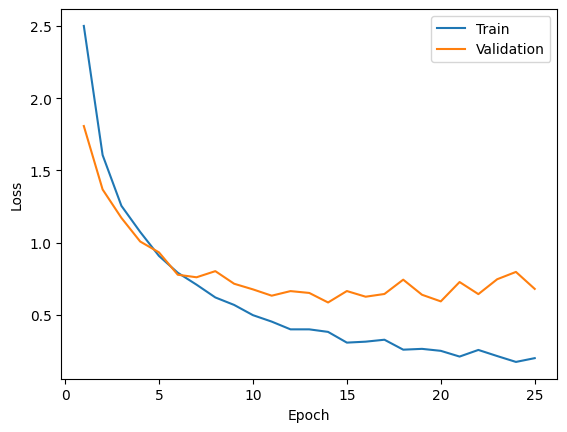

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_acc_history, label='Train')
plt.plot(range(1, num_epochs+1), test_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train')
plt.plot(range(1, num_epochs+1), test_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
from torchvision import transforms
from PIL import Image

# Load the custom ResNet model
model = CustomResNet(num_classes=len(categories))  # Replace NUM_CLASSES with the number of classes in your dataset

# Load the pre-trained weights (if any)
# If you have saved your model state_dict, you can load it using:
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))
# Otherwise, you can skip this step if you trained the model in the same session

# Set the model to evaluation mode
model.eval()

# Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the image using PIL
image = Image.open("/home/khushi/Testing_testing/Data/Updated_Data/Suction_Machine/suction machine in surgery_269_resized_.jpeg")
# Preprocess the image
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make predictions
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1)

# Get the predicted class index
predicted_class_index = torch.argmax(probabilities, dim=1).item()

# Optionally, get the class label based on the index
# Assuming you have a list of class labels
class_labels = categories  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class_index]

print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Label:", predicted_class_label)
print("Class Probabilities:", probabilities)


/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khushi/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Class Index: 22
Predicted Class Label: Suction_Machine
Class Probabilities: tensor([[0.0399, 0.0378, 0.0376, 0.0377, 0.0408, 0.0419, 0.0397, 0.0374, 0.0378,
         0.0442, 0.0374, 0.0367, 0.0422, 0.0377, 0.0412, 0.0385, 0.0363, 0.0419,
         0.0397, 0.0395, 0.0437, 0.0387, 0.0452, 0.0424, 0.0439]])


In [15]:
torch.save(model.state_dict(), "Resnet150")
#torch.save(model, "modelResNet.pt")
